# Data query for a Pulsar Wind Nebula Population study with H.E.S.S.

In this notebook the  Australia Telescope National Facility (ATNF, https://www.atnf.csiro.au/research/pulsar/psrcat/) is queried to find pulsars which are believed to host TeV pulsar wind nebulae.

Additionally, the High Energy Stereoscopic System (H.E.S.S.) archive is queried, to derive how much data on each of these pulsars has been aquired over the last 19 years. 

Queried are parameters which have been shown to have a high influence on the gamma-ray morphology and brighness.

In [ ]:
import astropy
import psrqpy as pq
from astropy import coordinates
import numpy as np
import pandas as pd
from importlib import reload
from astropy.coordinates import SkyCoord
from astropy import units as u

In [5]:
import sys  
sys.path.insert(1, '/home/wecapstor1/caph/mppi103h/hpc_documents/On-OFF-matching-woody')
import common_utils
from common_utils import get_excluded_regions
import runmatching_utilities as util

In [7]:
pulsar_tree = pd.read_csv('data_pulsartree_TeVPWNe_Branch.csv', sep=';', header=0)
pulsar_tree = pulsar_tree[~pulsar_tree['JNAME'].isin(['J1858+0239', 'J1903+0912', 'J1907+0833'])]
len(pulsar_tree)

159

In [8]:
database_path_woody = '/home/wecapstor1/caph/shared/hess/fits/database_image'
monitor_run_data = pd.read_csv('{}/data_1223.csv'.format(database_path_woody)).sort_values("Run", ascending=True)
DB_trigger = pd.read_csv('{}/trigger_1223.csv'.format(database_path_woody))

In [54]:
avail_data = pd.DataFrame(columns=['JNAME', 'lon', 'lat', 'observable', 'DIST [kpc]', 'Edot(ATNF) [erg/s]', 'P(ATNF) [s]', 'Pdot(ATNF)', 'OBS_TIME_tot [h]', 'OBS_TIME_det [h]'])
params = ['Dist', 'Edot', 'Age', 'P0', 'P1']

In [55]:
for i in range(0,len(pulsar_tree)):
    #pulsar properties
    pulsar_name = 'PSR '+ pulsar_tree['JNAME'].iloc[i]
    pulsar_coord = coordinates.SkyCoord.from_name(pulsar_name, frame='galactic')
    dist = pq.QueryATNF(params=params, psrs=[pulsar_tree['JNAME'].iloc[i]])
    dist_table = dist.table
    name = pd.DataFrame([pulsar_name], columns=['JNAME'])
    lon = pd.DataFrame([pulsar_coord.l.value], columns=['lon'])
    lat = pd.DataFrame([pulsar_coord.b.value], columns=['lat'])
    model_coord = SkyCoord(pulsar_coord.l.value*u.degree, pulsar_coord.b.value*u.degree, frame='galactic').icrs
    if model_coord.dec.value > 30:
        obs = 'No'
    else:
        obs = 'Yes'
    observable = pd.DataFrame([obs], columns=['observable'])
    table_dist = dist_table['DIST'][0]
    if np.ma.is_masked(table_dist):
        d = 1
    else:
        d = table_dist
    # d = 1 if table_dist.mask else table_dist
    dist = pd.DataFrame([d], columns=['DIST [kpc]'])
    try:
        dist_table['EDOT'][0].mask
        edot = pd.DataFrame([''], columns=['Edot(ATNF) [erg/s]'])
    except:
        edot = pd.DataFrame(['{:.2e}'.format(dist_table['EDOT'][0])], columns=['Edot(ATNF) [erg/s]'])
    try:
        dist_table['P0'][0].mask
        p= pd.DataFrame([''], columns=['P(ATNF) [s]'])
    except:
        p= pd.DataFrame(['{:.2e}'.format(dist_table['P0'][0])], columns=['P(ATNF) [s]'])
    try:
        dist_table['P1'][0].mask
        pdot = pd.DataFrame([''], columns=['Pdot(ATNF)'])
    except:
        pdot = pd.DataFrame(['{:.2e}'.format(dist_table['P1'][0])], columns=['Pdot(ATNF)'])
    #no cuts

    runlist = util.query_runs(TargetRA=model_coord.ra.value, TargetDec=model_coord.dec.value, Radius=2, TelPattern='fits')
    livetime = []
    for run in runlist:
        if monitor_run_data[monitor_run_data['Run']==run].empty == False and DB_trigger[DB_trigger['Run']==run].empty==False:
            if DB_trigger[DB_trigger['Run']==run]['Mean_Zenith'].iloc[0] < 55:
                livetime.append(monitor_run_data[monitor_run_data['Run']==run]['Duration'].iloc[0])
    tot_livetime = np.sum(livetime)/3600
    time = pd.DataFrame([tot_livetime], columns=['OBS_TIME_tot [h]'])
    
    #detection cuts
    quality_selection_hess1 = util.quality_selection(runlist=runlist, HessEra='HESS1', Config='stereo', FitsEra='HESS1', AnalysisType='detection')
    runlist_filtered_hess1 = quality_selection_hess1.quality_cuts(requireCT5=False, logBadRuns=False, off_run_sel=True)
    quality_selection_hess2 = util.quality_selection(runlist=runlist, HessEra='HESS2', Config='stereo', FitsEra='HESS2', AnalysisType='detection')
    runlist_filtered_hess2 = quality_selection_hess2.quality_cuts(requireCT5=False, logBadRuns=False, off_run_sel=True)
    quality_selection_hess1u = util.quality_selection(runlist=runlist, HessEra='HESS2', Config='stereo', FitsEra='HESS1u', AnalysisType='detection')
    runlist_filtered_hess1u = quality_selection_hess1u.quality_cuts(requireCT5=False, logBadRuns=False, off_run_sel=True)
    runlist_tot = runlist_filtered_hess1 + runlist_filtered_hess2 + runlist_filtered_hess1u
    livetime_det = []
    for run2 in runlist_tot:
        if monitor_run_data[monitor_run_data['Run']==run2].empty == False and DB_trigger[DB_trigger['Run']==run2].empty==False:
            if DB_trigger[DB_trigger['Run']==run2]['Mean_Zenith'].iloc[0] < 55:
                livetime_det.append(monitor_run_data[monitor_run_data['Run']==run2]['Duration'].iloc[0])
    tot_livetime_det = np.sum(livetime_det)/3600
    time_det = pd.DataFrame([tot_livetime_det], columns=['OBS_TIME_det [h]'])

    new_df = pd.merge(name, lon, left_index=True, right_index=True)
    new_df = pd.merge(new_df, lat, left_index=True, right_index=True)
    new_df = pd.merge(new_df, observable, left_index=True, right_index=True)
    new_df = pd.merge(new_df, dist, left_index=True, right_index=True)
    new_df = pd.merge(new_df, edot, left_index=True, right_index=True)
    new_df = pd.merge(new_df, p, left_index=True, right_index=True)
    new_df = pd.merge(new_df, pdot, left_index=True, right_index=True)
    new_df = pd.merge(new_df, time, left_index=True, right_index=True)
    new_df = pd.merge(new_df, time_det, left_index=True, right_index=True)
    avail_data = pd.concat([avail_data, new_df], ignore_index=True)

In [56]:
psr1 = ['PSR J1858+0239', 284.5750, 2.6644, 149.398611, 110.121389] #pos 129 in initial list starting at 3
psr2 = ['PSR J1903+0912', 285.9250, 9.2117,  60.809444,  45.143333] #pos 130
psr3 = ['PSR J1907+0833', 286.9875, 8.5667, 128.696389,  87.805000] #pos 134

In [57]:
psr = pd.DataFrame({'JNAME':['PSR J1858+0239', 'PSR J1903+0912', 'PSR J1907+0833', 'PSR J0954-5430'],
                    'lon':[36.09, 42.52, 42.43, 279.00],
                    'lat':[	-0.31, 1.49, 0.26, -0.10],
                    'observable': ['Yes', 'Yes', 'Yes', 'Yes'],
                    'DIST [kpc]':[5.86, 11.85, 8.31, 0.43],
                    'Edot(ATNF) [erg/s]':[7.2e+34, 1.3e+35, 3.1e+34, 1.6e+34],
                    'P(ATNF) [s]':[0.198, 0.166, 0.168, 0.473],
                    'Pdot(ATNF)':[1.40e-14, 1.48e-14, 3.70e-15, 4.39e-14],
                    'OBS_TIME_tot [h]':[135.0825, 60.809444, 128.696389, 21.833333333333332],
                    'OBS_TIME_det [h]':[98.13555, 45.143333, 87.805000, 20.699166666666667]})

In [58]:
final_data = pd.DataFrame(np.insert(avail_data.values, (126,127,131,159), psr.values, axis=0), columns=avail_data.columns)

In [59]:
full_tree = pd.read_csv('data_pulsartree_TeVPWNe_Branch.csv', sep=';', header=0)

In [61]:
final_data.to_csv('data_pulsartree_TeVPWNe_Branch_obstime_gal.csv', sep='\t', header=True)

# Number of observations 

In [74]:
questionable_pulsars = ['PSR J1809-2332']

In [75]:
runs = []
for i in range(0,len(questionable_pulsars)):
    #pulsar properties
    pulsar_name = questionable_pulsars[i]
    pulsar_coord = coordinates.SkyCoord.from_name(pulsar_name, frame='galactic')
    model_coord = SkyCoord(pulsar_coord.l.value*u.degree, pulsar_coord.b.value*u.degree, frame='galactic').icrs
    
    runlist = util.query_runs(TargetRA=model_coord.ra.value, TargetDec=model_coord.dec.value, Radius=2, TelPattern='fits')
    print(pulsar_name, len(runlist))

PSR J1809-2332 271


In [78]:
len([x for x in runlist if x < 177457])

113

In [73]:
for i in range(0,len(questionable_pulsars)):
    #pulsar properties
    pulsar_name = questionable_pulsars[i]
    pulsar_coord = coordinates.SkyCoord.from_name(pulsar_name, frame='galactic')
    model_coord = SkyCoord(pulsar_coord.l.value*u.degree, pulsar_coord.b.value*u.degree, frame='galactic').icrs
    runs = []
    
    runlist = util.query_runs(TargetRA=model_coord.ra.value, TargetDec=model_coord.dec.value, Radius=2, TelPattern='fits')
    livetime = []
    for run in runlist:
        if monitor_run_data[monitor_run_data['Run']==run].empty == False and DB_trigger[DB_trigger['Run']==run].empty==False:
            if DB_trigger[DB_trigger['Run']==run]['Mean_Zenith'].iloc[0] < 55:
                livetime.append(monitor_run_data[monitor_run_data['Run']==run]['Duration'].iloc[0])
        else:
            livetime.append(1680)
    print(pulsar_name, np.sum(livetime)/3600)

PSR J0437-4715 27.78
PSR J1741-2054 4.976944444444444
PSR J0954-5430 53.56666666666667
PSR J1543-5149 28.273888888888887
PSR J0614-3329 2.1525
PSR J2124-3358 8.000555555555556
PSR J1023+0038 5.676944444444445
PSR J1843-1113 5.384444444444444
PSR J1227-4853 17.376944444444444
PSR J1536-4948 12.289722222222222
PSR J1101-6101 10.371666666666666
PSR J1125-5825 16.342777777777776
PSR J1823-3021A 24.008055555555554
PSR J1901-0125 13.033333333333333
PSR J1810+1744 3.6930555555555555
PSR J1138-6207 26.035
PSR J1513-2550 29.805833333333332
PSR J0737-3039A 6.546388888888889
PSR J0023+0923 7.435555555555555
PSR J1745+1017 17.066388888888888
PSR J1857+0943 4.323055555555555
PSR J1548-5607 16.406944444444445
PSR J1822-0902 22.118333333333332
PSR J1824-0621 4.216944444444445
PSR J1231-5113 3.8844444444444446
PSR J1858-5422 2.3033333333333332


In [62]:
np.array(final_data['DIST [kpc]'])

array([6.357, 59.7, 1.768, 3.2, 1.0, 1.0, 2.0, 49.7, 49.7, 1.3, 49.7,
       4.583, 1.0, 2.0, 5.508, 0.28, 5.638, 1.0, 0.377, 2.732, 3.162,
       10.914, 3.277, 2.08, 1.423, 1.895, 2.9, 3.143, 3.83, 0.093, 7.0,
       1.0, 2.36, 1.0, 4.464, 8.4, 5.0, 1.0, 7.183, 1.0, 2.227, 1.0, 1.0,
       4.0, 10.699, 10.717, 2.6315598158677904, 12.6, 1.0, 3.1, 1.0, 5.0,
       7.0, 13.51, 1.0, 2.1500000000000004, 1.885, 5.632,
       1.9549999999999998, 8.543, 1.0, 1.8399999999999999, 3.371, 6.835,
       4.4, 1.0, 3.378, 2.841, 5.978, 5.702, 6.9, 2.948, 5.148, 1.0,
       4.743, 1.0, 1.0, 1.0, 3.442, 4.41, 12.75, 1.0, 4.467, 1.0, 5.046,
       2.6, 3.488, 3.497, 3.487, 0.641, 3.074, 1.227, 8.806, 1.0, 8.141,
       2.52, 1.0, 3.803, 4.4, 1.0, 3.268, 5.0, 2.635, 6.147, 3.152, 1.0,
       15.672, 3.7, 1.55, 3.606, 4.767, 3.683, 4.5, 4.1, 4.215, 3.159,
       4.779, 1.0, 6.6, 4.399, 1.0, 5.063, 5.8, 1.0, 5.339, 6.318, 5.86,
       1.0, 11.85, 7.4, 2.37, 10.116, 8.216, 8.31, 3.043, 4.607, 14.003,
    

In [55]:
for i in range(0,len(full_tree)):
    if full_tree['Dec.'].iloc[i]>35 and full_tree['OBS_TIME_tot [h]'].iloc[i] >0:
        print(i)

149


In [68]:
 full_tree

,AGE,BLC,BSURF,CB,EDOT,GJC,JNAME,P0,P1,PC1,...,index,TeVPWN,Unnamed: 14,R.A.,Dec.,DIST,DIST1,Edot(ATNF),OBS_TIME_tot [h],OBS_TIME_det [h]
0,"3,063E+08","5,127E+06","8,396E+14",5.0,"1,534E+38","5,034E+14",J0002+6216,"1,154E+02","5,967E-12",-421.0,...,0,NaN,NaN,0.742375,62.269278,6.357,7.892,1.53e+35,0.0,0.0
1,"1,193E+07","7,297E+08","8,026E+14",1.0,"1,106E+41","2,551E+15",J0058-7218,"2,177E+01",2.89e-14,-99.0,...,33,NaN,NaN,14.570208,-72.301556,59.7,59.7,1.11e+38,58.196111,36.043056
2,"2,747E+08","7,001E+06","7,795E+14",0.0,"2,213E+38","5,316E+14",J0117+5914,"1,014E+02",5.85e-15,-348.0,...,48,NaN,NaN,19.411088,59.243997,1.768,2.235,2.21e+35,0.0,0.0
3,"5,374E+06","1,193E+08","3,611E+15",8.0,"2,695E+40","3,801E+15",J0205+6449,"6,572E+01","1,938E-10",-1312.0,...,70,Yes,3C 58,31.408,64.828556,3.2,3.2,2.70e+37,0.0,0.0
4,"5,638E+08","2,056E+06","8,389E+14",8.0,"4,537E+37","3,711E+14",J0358+5413,"1,564E+02","4,395E-12",-474.0,...,110,NaN,NaN,59.723819,54.22048,1.0,1.0,4.54e+34,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,"1,748E+07","1,147E+07","4,808E+15",15.0,"1,436E+39","2,107E+15",J2111+4606,"1,578E+02","1,43E-10",-1659.0,...,2492,NaN,NaN,317.850521,46.108517,NaN,NaN,1.44e+36,0.0,0.0
158,"4,388E+08","2,679E+06","8,871E+14",5.0,"6,698E+37","4,206E+14",J2116+3701,"1,459E+02","5,267E-12",-499.0,...,2500,NaN,NaN,319.0596,37.025314,2.926,2.8,6.70e+34,0.0,0.0
159,"1,057E+07","1,377E+08","2,023E+15",0.0,"2,218E+40",2.71e+12,J2229+6114,"5,165E+01","7,739E-11",-877.0,...,2554,Yes,Boomerang,337.271925,61.235689,3.0,3.0,2.22e+37,0.0,0.0
160,"2,657E+07","8,748E+06","4,021E+15",4.0,"8,889E+38","1,709E+15",J2238+5903,"1,627E+02","9,703E-11",-1544.0,...,2563,Yes_unid,1LHAASO J2238+5900,339.617037,59.062047,2.83,2.83,8.89e+35,0.0,0.0


In [68]:
from astropy import units as u
coordinates.SkyCoord(21.94*u.deg, -0.078*u.deg, frame='galactic').icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (277.86830917, -9.80614621)>

In [36]:
runlist = util.query_runs(TargetRA=308.029167, TargetDec=41.508333	, Radius=2, TelPattern='fits')
livetime = []
for run in runlist:
    if monitor_run_data[monitor_run_data['Run']==run].empty == False:
        livetime.append(monitor_run_data[monitor_run_data['Run']==run]['Duration'].iloc[0])
tot_livetime = np.sum(livetime)/3600

#detection cuts
quality_selection_hess1 = util.quality_selection(runlist=runlist, HessEra='HESS1', Config='stereo', FitsEra='HESS1', AnalysisType='detection')
runlist_filtered_hess1 = quality_selection_hess1.quality_cuts(requireCT5=False, logBadRuns=False, off_run_sel=True)
quality_selection_hess2 = util.quality_selection(runlist=runlist, HessEra='HESS2', Config='stereo', FitsEra='HESS2', AnalysisType='detection')
runlist_filtered_hess2 = quality_selection_hess2.quality_cuts(requireCT5=False, logBadRuns=False, off_run_sel=True)
quality_selection_hess1u = util.quality_selection(runlist=runlist, HessEra='HESS2', Config='stereo', FitsEra='HESS1u', AnalysisType='detection')
runlist_filtered_hess1u = quality_selection_hess1u.quality_cuts(requireCT5=False, logBadRuns=False, off_run_sel=True)
runlist_tot = runlist_filtered_hess1 + runlist_filtered_hess2 + runlist_filtered_hess1u
livetime_det = []
for run2 in runlist_tot:
    if monitor_run_data[monitor_run_data['Run']==run2].empty == False:
        livetime_det.append(monitor_run_data[monitor_run_data['Run']==run2]['Duration'].iloc[0])
tot_livetime_det = np.sum(livetime_det)/3600

In [37]:
print(tot_livetime)
print(tot_livetime_det)

17.400555555555556
15.400833333333333


# HGPS contours

In [91]:
from gammapy.datasets import Datasets, MapDataset
from astropy.coordinates import SkyCoord, SkyOffsetFrame

import os,sys
import numpy as np
import matplotlib.pyplot as plt

import gammapy
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, SkyOffsetFrame


import astropy.units as u

In [118]:
dataset12 = MapDataset.read('2HGPS/datasets/GPS-hess12-z40-z65_500GeV-100TeV_iter1.fits', 
                              name='HESS12')

dataset1u = MapDataset.read('2HGPS/datasets/GPS-hess1u-z40-z65_500GeV-100TeV_iter1.fits', 
                              name='HESS1u')

In [119]:
datasets = Datasets([dataset12, dataset1u])

In [120]:
combined = datasets.stack_reduce()

<WCSAxes: >

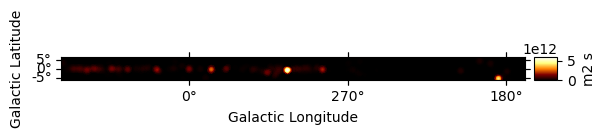

In [121]:
dataset12.exposure.sum_over_axes().plot(add_cbar=True)

<WCSAxes: >

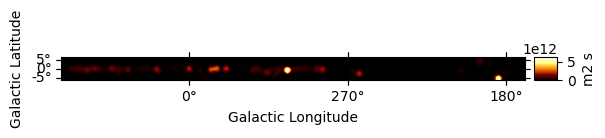

In [122]:
combined.exposure.sum_over_axes().plot(add_cbar=True)

In [123]:
comb_exp = combined.exposure.sum_over_axes()

In [124]:
comb_exp.write('exposuremap_hgps_hess12_1u_z40-z65_500GeV-100TeV.fits', overwrite=True)

In [98]:
lonrange = [(62.,41.),(43,20), (21,1), (3,341), (343,321), (323,301), (303,281), (283,262)]
filename = '2HGPS/maps/significance_filtered_0.1deg_GPS-hess12_1u_500GeV-100TeV_iter1_step0.fits'

def plot_hgps_contour(lt):
    f = plt.figure(figsize=(20,7))

    hgps_sig = dataset1u.exposure.sum_over_axes()

    cut_pos = SkyCoord((lt[1]+11.)* u.deg, 0.* u.deg, frame="galactic") 
    hgps_cut = hgps_sig.cutout(position=cut_pos,width=(22.,7.)*u.deg) #size of region (5.)

    geom = hgps_cut.geom

    #ax = plt.subplot(111,projection=geom.wcs)
    #ax.tick_params(axis='both', which='major', labelsize=10)

    hgps_cut.plot(add_cbar=True)
    # #Add contours at 3, 5 and 15 sigma
    # levels = [3,5,15]
    # ax.contour(np.squeeze(hgps_cut.sum_over_axes().data), levels, colors=['black','green','cyan'], alpha=1)

    
    #ax.set_xlabel("Galactic Longitude (deg)",fontsize=12)
    #ax.set_ylabel("Galactic Latitude (deg)",fontsize=12)
    

    return

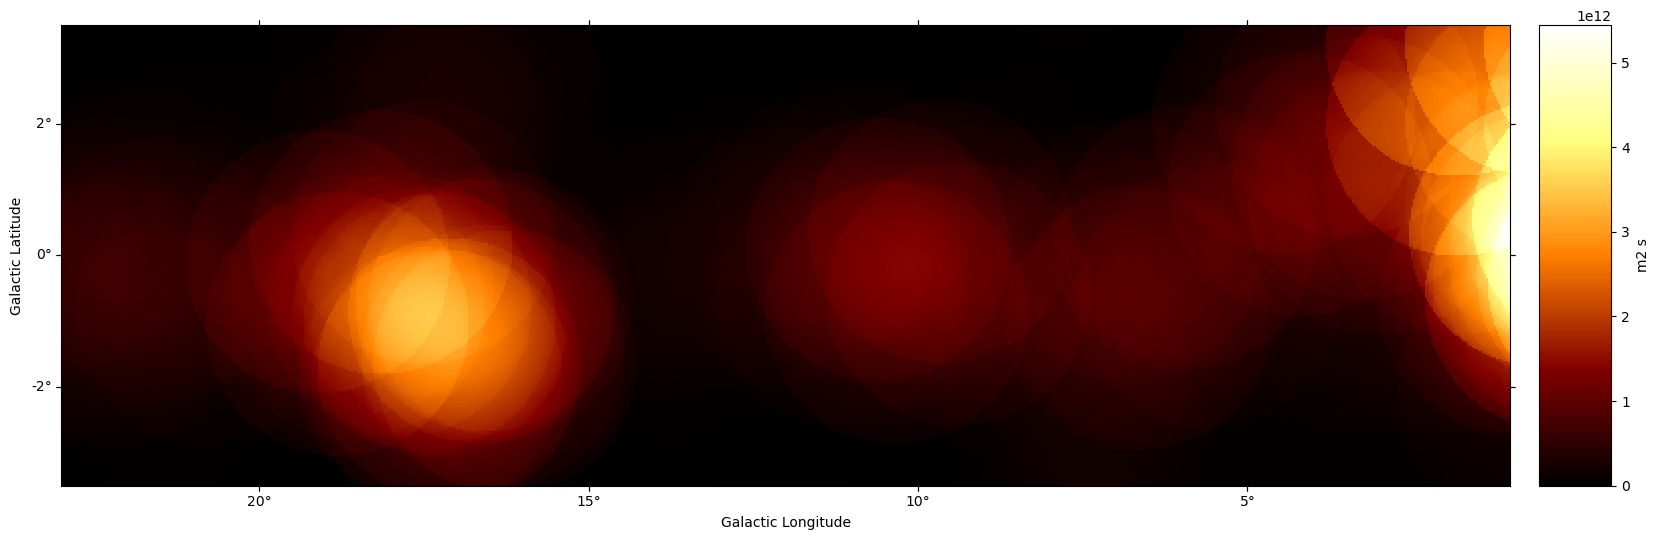

In [97]:
plot_hgps_contour(lonrange[2])

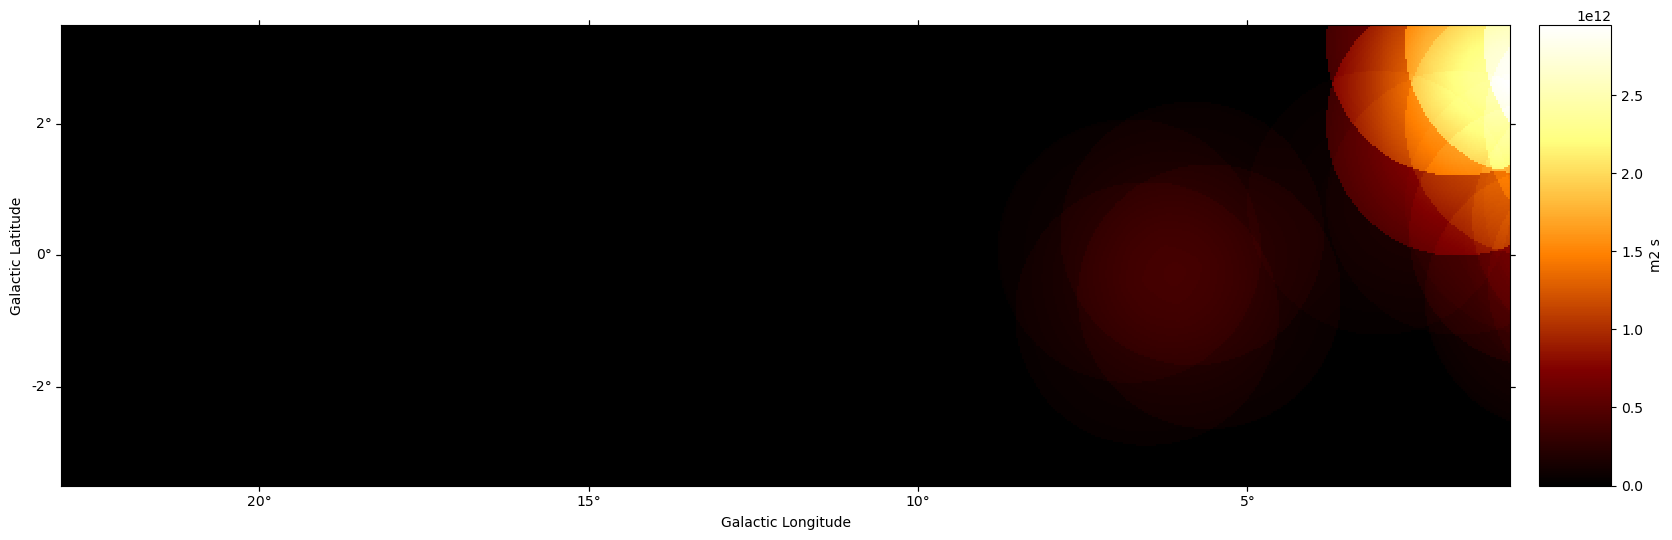

In [99]:
plot_hgps_contour(lonrange[2])